# Fashion-MNIST analysis
_Franciszek Urbański_

## Dataset overview
According to [Kaggle](https://www.kaggle.com/datasets/zalando-research/fashionmnist), Fashion-MNIST is a dataset of Zalando's article images. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct replacement for the original MNIST dataset for benchmarking machine learning and data science algorithms.

![All Fashion-MNIST images](https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/refs/heads/master/doc/img/fashion-mnist-sprite.png)


What we see above is a sample from all the classes in the dataset ([GitHub](https://github.com/zalandoresearch/fashion-mnist)). We can see that also within the classes, we have quite a lot of variety. For instance, some clothing items are lighter, and some are brighter. Also, shapes of items are varied - for instance, some bags have a handle, some shoes have heels, some tops are more unique than just a T-shirt. This might make the analysis more problematic/interesting.

Let's start our analysis by setting up our environment - some basic imports, setting a value to be used for `random_state` in some algorithms and setting a seed value for `numpy`'s RNG (for reproducibility). Finally, we'll load our dataset.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

RS = 20040304
np.random.seed(RS)

df_train = pd.read_csv("data/fashion-mnist_train.csv")
df_test = pd.read_csv("data/fashion-mnist_test.csv")

I downloaded the dataset from [Kaggle](https://www.kaggle.com/datasets/zalando-research/fashionmnist). It is split into two parts - 60'000 samples to be used for training, and 10'000 for testing. Each sample consists of 785 columns, 784 of which are darkness values (integers from 0 to 255) for consecutive pixels of the 28x28 image, while one is the label, representing the category of the clothing item:

| label | category          |
|-------|-------------------|
| 0     | T-shirt/top       |
| 1     | Trousers          |
| 2     | Pullover          |
| 3     | Dress             |
| 4     | Coat              |
| 5     | Sandal            |
| 6     | Shirt             |
| 7     | Sneaker           |
| 8     | Bag               |
| 9     | Ankle boot        |

Each of the classes is equally represented within the dataset. Furthermore, the dataset doesn't contain any missing values.

Apart from the classification task, I don't need the dataset to be split between training and testing, so I will create a dataframe containing both those subsets merged. Let's also normalize the data (apart from the label column of course) - it might not be strictly necessary, since each parameter is scaled in an identical way, but some algorithms may work better with real values from 0 to 1.

At this point we may also look at the head of our dataset, to see if our import was successful.

In [53]:
labels = [
    'T-shirt/top',
    'Trousers',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
]

def normalize(df, exclude_col):
    df_n = df.drop(columns=exclude_col)
    df_n = df_n / 255.
    df_n[exclude_col] = df[exclude_col]
    return df_n

df_train = normalize(df_train, 'label')
df_test = normalize(df_test, 'label')

df = pd.concat([df_train, df_test], ignore_index=True)
df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,label
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,9
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,0.0,...,0.0,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0,6
3,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,3


Let's also create dataframes representing our dataset without the label column (so only the image pixels) - they will be used very extensively throughout the analysis. 

In [54]:
df_train_px = df_train.drop(columns='label')
df_test_px = df_test.drop(columns='label')
df_px = df.drop(columns='label')

df_px.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,0.0,...,0.000000,0.0,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,0.0,...,0.011765,0.0,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


To see that the dataset does indeed contain images, I wrote a simple `plot_image` function. Here we can see that the first image in the dataset is a nice sweater.

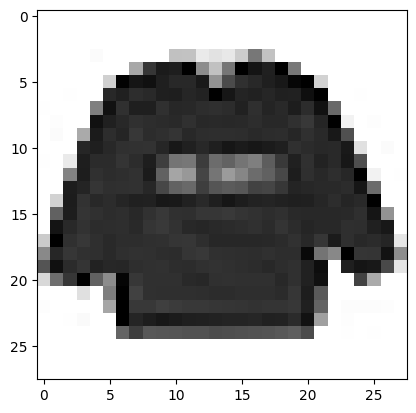

In [55]:
def get_image_arr(df, index):
    return df.iloc[index, :].to_numpy()

def plot_image(arr, x = 28, y = 28):
    img = arr.reshape(x, y)
    plt.imshow(img, cmap='gray_r', vmin=0, vmax=1)

plot_image(get_image_arr(df_px, 0))

An interesting way to visualize the dataset using the `plot_image` function is seeing what the average clothing item looks like. This shows that the dataset contains a lot of redundant data - corners are always white, and the middle is usually black.

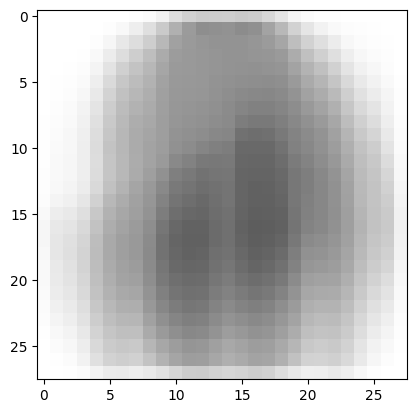

In [56]:
def plot_average_of(classes):
    plot_image(np.mean(df_px.loc[df['label'].isin(classes)].to_numpy(), axis=0))

plot_average_of([i for i in range(len(labels))])

One could also plot the average clothing item in a class. For instance, here we can see the average T-shirt/top:

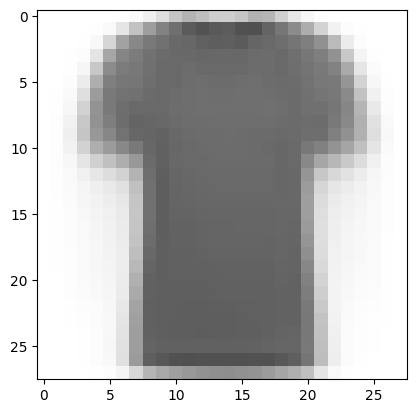

In [57]:
plot_average_of([0]) # the list of indices can be updated to plot averages of different classes

Let us now proceed with the first task, which is data dimensionality reduction.

## Dimensionality reduction

### PCA

Since the images contain a lot of redundant data, I have decided to use PCA as a first step in the dimensionality reduction process. I expect that a lot of the principal components will be insignificant. This reduction will be fast, and the reduced dataset can be used for more computationally demanding algorithms.

Let's first look at the scree plot of the dataset.

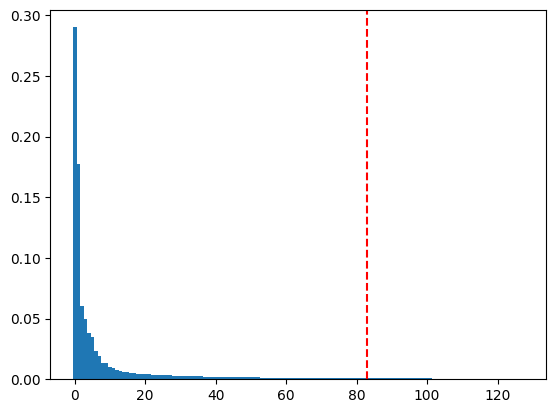

In [58]:
from sklearn.decomposition import PCA

pca = PCA(random_state=RS)
pca.fit(df_px)
scree_data = pca.explained_variance_ratio_

# 90% of the variance should remain
thresh = 0.9

sum = 0
idx = 0
for idx, el in enumerate(scree_data):
    sum += el
    if sum > thresh:
        break

scree_len = 128
plt.axvline(x=idx, color='red', linestyle='--', linewidth=1.5)
# plt.yscale('log')
plt.bar(range(scree_len), scree_data[:scree_len], width=1)
plt.show()

As expected, the scree plot (with the x axis clipped to 128 from the original 784, to improve readability) shows that the vast majority of principal components are insignificant. 

The red line on the scree plot represents the point to which I have decided to reduce the dimensionality, so that 90% of the variance remains (as it was suggested on the lecture). 

An interesting approach to visualising the components is plotting them as images (0 - white, 1 - black), to see the patterns that they represent. I found the component with index 1 to be particularly entertaining, since it looks like a pair of trousers. Components with higher indices are much more messy - component 32 only barely resembles the silhouette of a clothing item, whereas component 512 is an almost complete mess.

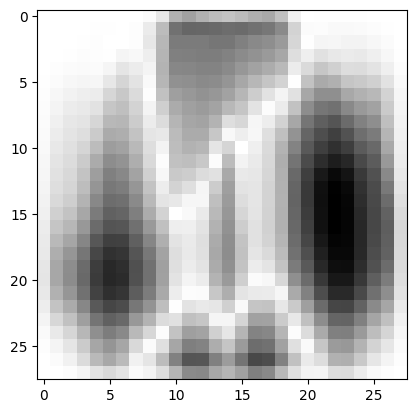

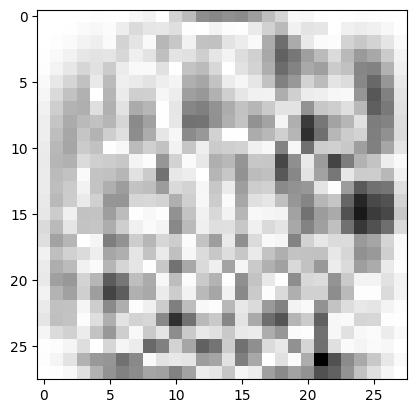

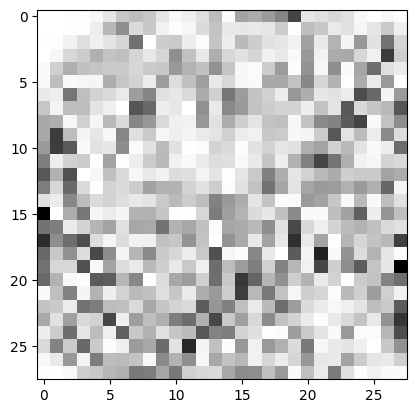

In [59]:
def plot_component(component_idx):
    def component_normalize(arr):
        return arr / np.max(arr)

    plot_image(component_normalize(np.abs(pca.components_[component_idx])))
    plt.show()

plot_component(1)
plot_component(32)
plot_component(512)

Let's now perform the actual reduction, with the calculated targer number of components. 

In [60]:
n_components = idx + 1
pca = PCA(n_components=n_components, random_state=RS)
reduced_pca = pca.fit_transform(df_px)
print(f"Dimensionality reduced to: {n_components}")

Dimensionality reduced to: 84


### t-SNE

Next, to be able to visualise the dataset, I decided to apply some more advanced algorithms to the PCA-reduction result. The first algorithm I tried was t-SNE. It turned out to be rather slow, and during the test phase I had to perform some sample size reduction to speed up the process.

In [61]:
from sklearn.manifold import TSNE

# df_pick_ratio = 0.1
df_pick_ratio = 1.0
df_mask = np.random.choice([True, False], size=len(reduced_pca), p=[df_pick_ratio, 1 - df_pick_ratio])

tsne = TSNE(n_components=2, random_state=RS)
reduced_tsne = tsne.fit_transform(reduced_pca[df_mask])

Let's now visualize the result of our reduction, with a 2d plot color-coded to represent our dataset's labels.

In [62]:
from matplotlib.colors import ListedColormap

def plot_2d(reduced, df_mask):
    colors = ['red', 'orange', 'gold', 'greenyellow', 'green', 'cyan', 'blue', 'darkviolet', 'magenta', 'chocolate']
    cmap = ListedColormap(colors)

    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10, label=l) for i, l in enumerate(labels)]
    
    # Add legend
    plt.legend(handles=legend_handles, title='Categories', loc='upper right', bbox_to_anchor=(1.3, 1), borderaxespad=0.)

    plt.scatter(reduced[:, 0], reduced[:, 1], c=df['label'][df_mask], cmap=cmap, s=1, alpha=0.04/(np.sum(df_mask)/len(df_mask)))
    plt.show()

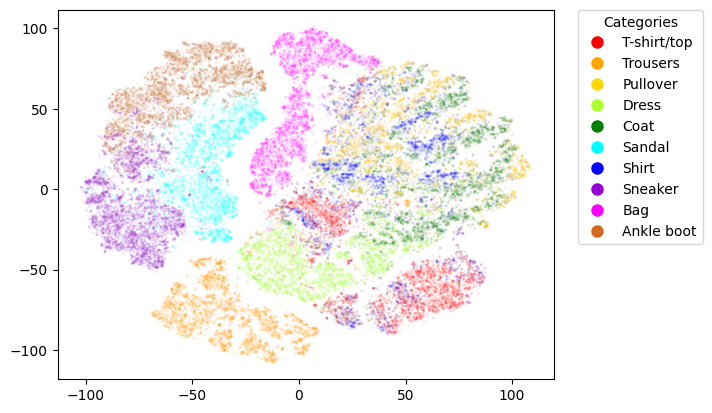

In [63]:
plot_2d(reduced_tsne, df_mask)

t-SNE managed to separate some of the categories, but most of them remained jumbled together. Trousers and bags are very well separated from the remaining clothing items, which is reasonable, since their shapes are quite distinct. Sandals, ankle boots and sneakers are in three corners of one cluster (the 'shoe cloud') - this also makes perfect sense, as shoes are quite similar to each other in shape, while also being quite distinct from the rest.

The problems however begin with the upper garments. T-shirts/tops and dresses are separated best, but the T-shirt/top cloud is separated into two parts. This is potentially due to women's tops having slightly different shapes than men's. Pullovers, coats and shirts are very hard to separate, albeit with part of the coat and shirt classes forming curious looking finger-like structures on the plot.

With hopes of achieving better separation (potentially handling better the upper garments), I have decided to try out another algorithm, which I heard is faster and more efficient than t-SNE - UMAP.

### UMAP
UMAP did indeed prove to be much faster - so much faster in fact, that I was able to run it on the full dataset, which produced clearer-looking results than those I achieved when running it on the PCA result. I have settled on `n_neighbors = 16` and `min_dist = 0.1`, since they seemed to provide a good balance, making the clusters concentrated but at the same time not splitting them into too many smaller subclusters.

In [64]:
from umap import UMAP

df_pick_ratio = 1.0
df_mask = np.random.choice([True, False], size=len(df_px), p=[df_pick_ratio, 1 - df_pick_ratio])

umap = UMAP(n_components=2, random_state=RS, n_neighbors=16, min_dist=0.1)
reduced_umap = umap.fit_transform(df_px[df_mask])

/home/frun/agh/sem5/fods/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


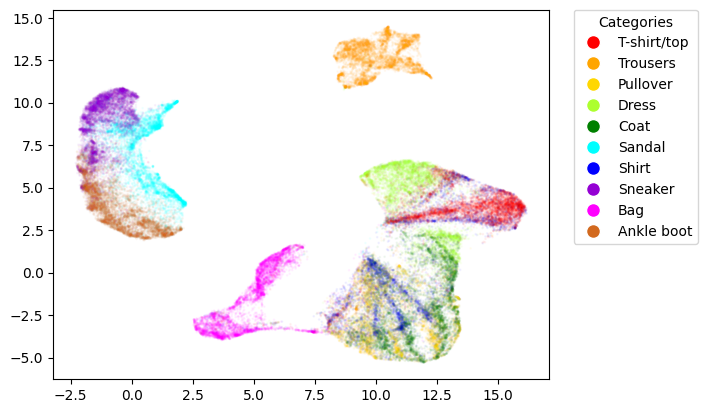

In [65]:
plot_2d(reduced_umap, df_mask)

The results produced by UMAP are arguably a bit better than those produced by t-SNE. It managed to make each cluster denser, and made the finger-like structures among upper garments more pronounced.

I conclude, that using those algorithms the dataset cannot be represented in 2d as well as e.g. the MNIST handwritten digit dataset, achieving clear separation of all the classes. Clustering therefore needs to be performed in a higher dimensional space.

For visualisation purposes I will be using the UMAP result - I find the class separation to be far clearer.

## Clustering
I will test different clustering algorithms, and compare their results by computing the adjusted rand index (I found the regular rand index to report deceptively high success rates), the silhouette score (for internal validation), and also performing visual inspection of the plotted dataset and the contingency martix.

### KMeans
First, I decided to try the KMeans algorithm, since it is fast and simple. It also gives us the benefit of being able to specify how many clusters we expect (in our case we know that we are dealing with 10 classes).

In [66]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, ConfusionMatrixDisplay, silhouette_score
from sklearn.metrics.cluster import contingency_matrix

df_mask_all = np.ones(len(df), dtype=bool)

kmeans = KMeans(n_clusters=10, random_state=RS)
# kmeans.fit(df_px) # adjuster_rand_index = 0.37
# kmeans.fit(reduced_pca) # adjuster_rand_index = 0.38
# kmeans.fit(reduced_tsne) # adjuster_rand_index = 0.33
kmeans.fit(reduced_umap) # adjuster_rand_index = 0.42

print(f"Adjusted rand index: {adjusted_rand_score(df['label'], kmeans.labels_)}")
print(f"Silhouette score: {silhouette_score(reduced_umap, kmeans.labels_, random_state=RS, sample_size=7000)}")

Adjusted rand index: 0.4230780432504995
Silhouette score: 0.4757368564605713


I performed the clustering on all my reduced datasets, and found the adjusted rand index values (see comments in code) a little bit surprising, especially the fact that the results on the 2d UMAP-reduced space were the best. A silhouette score of around 0.48 shows, that the clusters are somewhat defined, but not perfect - this isn't necessarily due to our clustering, but potentially to the fact that the number of clusters is potentially suboptimal for the dataset (since classes could have been chosen arbitrarily). Even then however, the adjusted rand index value isn't satisfactory. Let us now visualize our results.

In [67]:
def plot_clusters(points, cluster_labels, df_mask):
    max_label = np.max(cluster_labels)
    colors = np.array([plt.cm.gist_rainbow(label / (max_label + 1)) if label >= 0 else [0.5, 0.5, 0.5, 1.0] for label in cluster_labels])

    plt.scatter(points[:, 0], points[:, 1], c=colors, s=1, alpha=0.04/(np.sum(df_mask)/len(df_mask)))
    plt.show()

def plot_contingency_matrix(true_labels, predicted_labels, noise=False):
    m = contingency_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(m, display_labels=labels)
    disp.plot()
    x_ticks = [i for i in range(len(np.unique(predicted_labels)))]
    x_labels = [i - (1 if noise else 0) for i in range(len(np.unique(predicted_labels)))]
    plt.xticks(ticks=x_ticks, labels=x_labels)
    plt.show()

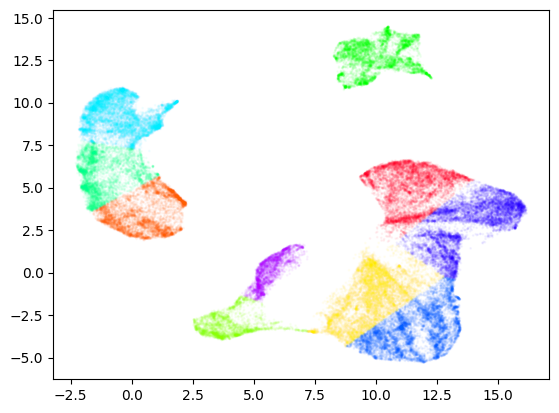

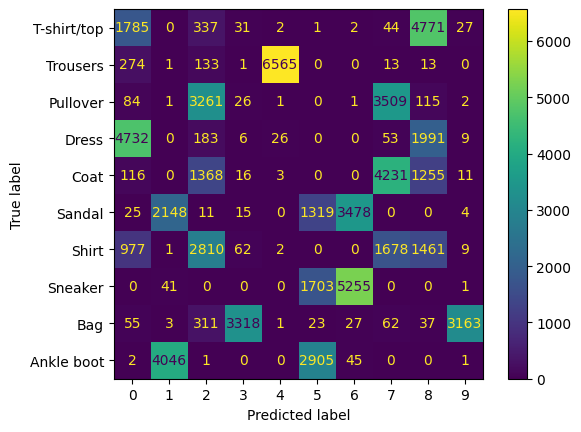

In [68]:
plot_clusters(reduced_umap, kmeans.labels_, df_mask_all)
plot_contingency_matrix(df['label'], kmeans.labels_)

As we can see on the 2d dataset plot, some of the cluster borders are a little bit awkwardly placed - probably due to KMeans trying to detect spherical clusters among the data.

The contingency matrix can be read similarly as the confusion matrix, only we need to take into account that the predicted labels can be permutated in any way. As we can see, the trousers were clustered nearly perfectly, but this cannot be said about the remaining classes. The shoes got quite confused among each other, and bags got separated into two groups (presumably clutch bags and bags with a handle - their separation might actually be a good thing, since the initial assignment of classes could have been quite arbitrary). The upper garments also proved quite problematic, with dresses, T-shirts/tops and coats being most easily distinguishable, and shirts being nearly impossible to identify. This was to be expected, since even knowing the layout of the clusters in the 2d space, it was difficult to separate some of those clusters.

Since the UMAP reduced dataset (even though it was only 2-dimensional) produced the best result, I decided to try and reduce the dimensionality with UMAP to some higher number, with hopes of achieving better results. This was also made possible by the fact that UMAP scales well even with higher target dimensionality.

In [69]:
umap_cluster = UMAP(n_components=32, n_neighbors=16, min_dist=0.1, random_state=RS)
reduced_umap_cluster = umap_cluster.fit_transform(df_px)

/home/frun/agh/sem5/fods/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [70]:
kmeans.fit(reduced_umap_cluster) # 0.49
print(f"Adjusted rand index: {adjusted_rand_score(df['label'], kmeans.labels_)}")
print(f"Silhouette score: {silhouette_score(reduced_umap_cluster, kmeans.labels_, random_state=RS, sample_size=7000)}")

Adjusted rand index: 0.49069263323545953
Silhouette score: 0.4875490069389343


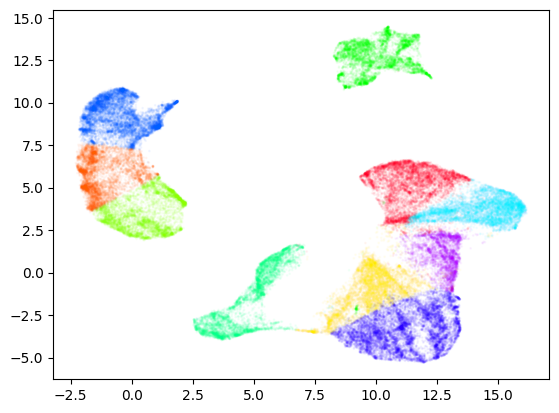

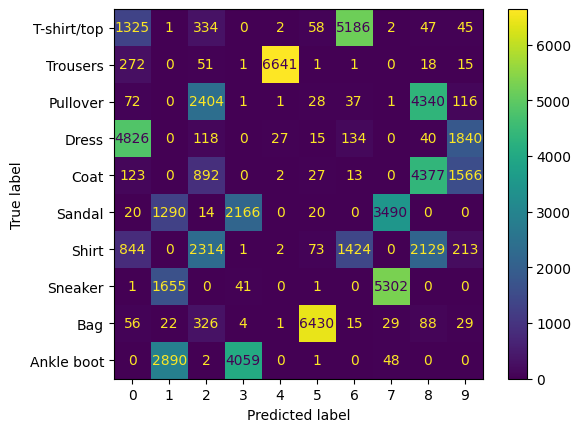

In [71]:
plot_clusters(reduced_umap, kmeans.labels_, df_mask_all)
plot_contingency_matrix(df['label'], kmeans.labels_)

The results look a bit better than those achieved before. Bags have now been properly clustered, and there is less confusion among the shoes and upper garments. The achieved silhouette score is very similar.

I tried running the clustering with different target UMAP dimensionalities (16, 32, 64, 128). Each time I got a very similar adjusted rand score (between 0.45 and 0.51). The larger the dimensionality, however, the longer both the UMAP reduction and KMeans clustering took. I settled on 32, since it provided the best balance between performance and efficacy. 

Still, an adjuster rand score of 0.5 isn't really satisfactory. This might be due to the fact, that KMeans is good at detecting spherical clusters, whereas our clusters (at least in the 2d space) don't look particularily spherical. I therefore proceeded to more advanced clustering methods.

### DBSCAN
I decided to first try density-based clusterings - the UMAP-reduced dataset in 2d looked like a lot of the clusters are distinguishable as areas of increased density, and so I concluded that the 32d reduced set I will be working on may exhibit similar properties. First of those algorithms was DBSCAN. A lot of parameter tweaking was needed to achieve at least partially satisfactory results.

In [72]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.66, min_samples=605)
dbscan.fit(reduced_umap_cluster) # 0.49; 3.7s

print(np.unique(dbscan.labels_))
print(f"Adjusted rand index: {adjusted_rand_score(df['label'], dbscan.labels_)}")
print(f"Silhouette score: {silhouette_score(reduced_umap_cluster, dbscan.labels_, random_state=RS, sample_size=7000)}")
print(f"Noise ratio: {(dbscan.labels_ == -1).sum() / len(dbscan.labels_)}")

[-1  0  1  2  3  4  5  6  7  8  9]
Adjusted rand index: 0.4904857645473201
Silhouette score: 0.4474654793739319
Noise ratio: 0.04214285714285714


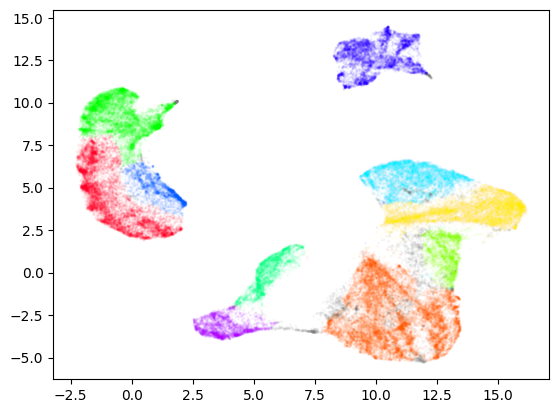

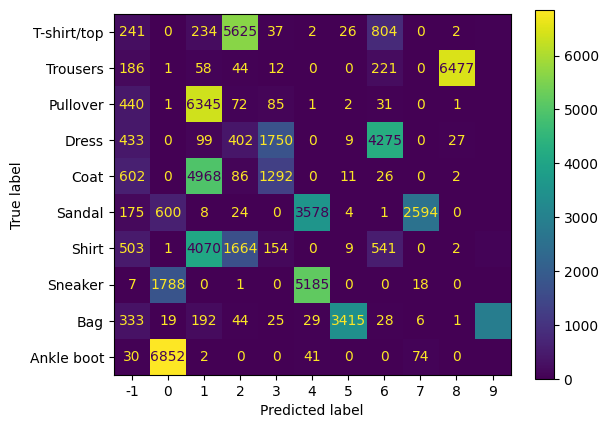

In [73]:
plot_clusters(reduced_umap[df_mask_all], dbscan.labels_, df_mask_all)
plot_contingency_matrix(df['label'], dbscan.labels_, noise=True)

Visually, the results look slightly different than those from KMeans - the clusters shapes are much more elaborate. The numbers however aren't that appealing - I couldn't get the adjusted rand index to exceed the one generated by KMeans. The silhouette score is also lower than before. We also experience some noise, inbetween the denser cluster areas - there isn't much of it, however, with the current algorithm parameters. By analyzing the contingency matrix, we can see that the algorithm performed better for the shoes and even managed to relatively well cluster shirts (the most problematic up till now), but again split the bags into two datasets.

Still dissatisfied with the results, I decided to take a look at the overview of clustering methods from the [scikit-learn website](https://scikit-learn.org/1.5/modules/clustering.html#overview-of-clustering-methods). As my next candidate, I chose spectral clustering - it seemed to be able to deal with the shapes of data that I imagined the dataset to be. It also allowed me to specify the desired number of clusters. The algorithm was however very slow, and I had to reduce my sample size to 10% to be able to experiment with it efficiently.

In [74]:
from sklearn.cluster import SpectralClustering

df_pick_ratio = 0.1
df_mask_sc = np.random.choice([True, False], size=len(reduced_pca), p=[df_pick_ratio, 1 - df_pick_ratio])

sc = SpectralClustering(n_clusters=10, random_state=RS, n_neighbors=256)
sc.fit(reduced_umap_cluster[df_mask_sc])

print(f"Adjusted rand score: {adjusted_rand_score(df['label'][df_mask_sc], sc.labels_)}")
print(f"Silhouette score: {silhouette_score(reduced_umap_cluster[df_mask_sc], sc.labels_, random_state=RS)}")

Adjusted rand score: 0.46164874832879144
Silhouette score: 0.5123791694641113


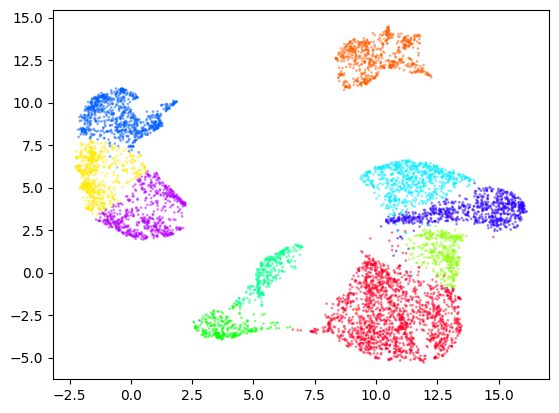

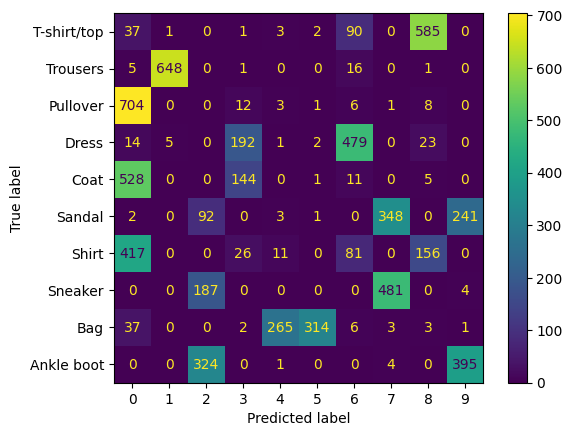

In [75]:
plot_clusters(reduced_umap[df_mask_sc], sc.labels_, df_mask_sc)
plot_contingency_matrix(df['label'][df_mask_sc], sc.labels_)

Again, I didn't manage to achieve better results than those provided by KMeans. The results are comparable to those achieved with DBSCAN.

### Agglomerative clustering
For completeness, I decided to try the hierarchical approach to clustering, provided by agglomerative clustering - again on a reduced sample size, for performance reasons.

In [76]:
from sklearn.cluster import AgglomerativeClustering

df_pick_ratio = 0.25
df_mask_ac = np.random.choice([True, False], size=len(reduced_pca), p=[df_pick_ratio, 1 - df_pick_ratio])

ac = AgglomerativeClustering(n_clusters=10, linkage='average', metric='manhattan')
ac.fit(reduced_umap_cluster[df_mask_ac])

print(f"Adjusted rand score: {adjusted_rand_score(df['label'][df_mask_ac], ac.labels_)}")
print(f"Silhouette score: {silhouette_score(reduced_umap_cluster[df_mask_ac], ac.labels_, random_state=RS, sample_size=7000)}")

Adjusted rand score: 0.44950884892907
Silhouette score: 0.4417683780193329


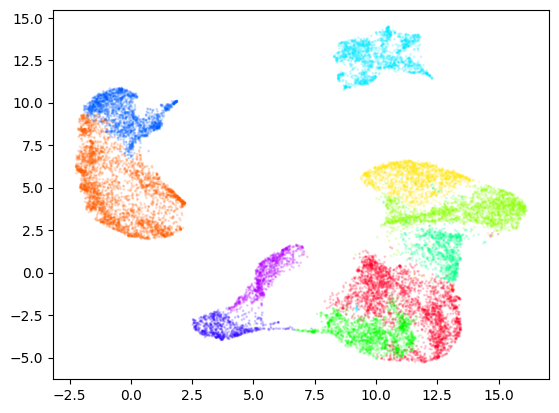

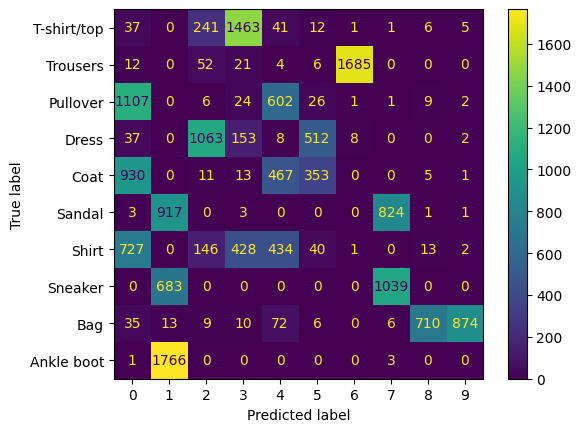

In [77]:
plot_clusters(reduced_umap[df_mask_ac], ac.labels_, df_mask_ac)
plot_contingency_matrix(df['label'][df_mask_ac], ac.labels_)

The results are again very similar, showing no reasonable improvement. 

From our attempts to cluster the data we can draw the conclusion, that the dataset is too complex to be reliably clustered. Each of the clustering approaches performed better in different areas, but ultimately none of those I tried was successful. This isn't neccessarily the fault of insufficient algorithms - some of the images between different categories are quite similar to each other (especially among the upper garments), and I myself sometimes have issues deciding whether what I see is a pullover or a shirt.

Let us now see, whether classification manages to detect patterns in the dataset more reliably than clustering.

## Classification
The task of splitting the dataset into training and testing has already been done for us by Kaggle. I will therefore refrain from doing this myself.

In [78]:
X_train, X_test, y_train, y_test = df_train_px, df_test_px, df_train['label'], df_test['label']

### K nearest neighbors

The first classifier I decided to try was the K nearest neighbors classifier, since it is simple and fast. 

In [79]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
predictions_knn = knn.predict(X_test)

In [80]:
def evaluate_classifier(true_labels, predicted_labels):
    m = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(m, display_labels=[l for l in labels])
    disp.plot(xticks_rotation=45)
    plt.show()
    print(classification_report(true_labels, predicted_labels, target_names=[l for l in labels]))

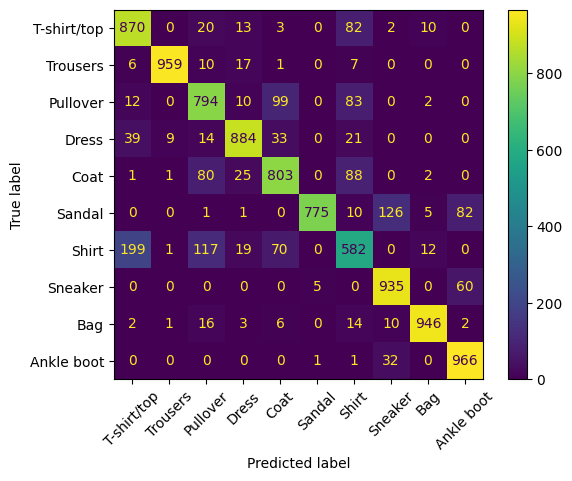

              precision    recall  f1-score   support

 T-shirt/top       0.77      0.87      0.82      1000
    Trousers       0.99      0.96      0.97      1000
    Pullover       0.75      0.79      0.77      1000
       Dress       0.91      0.88      0.90      1000
        Coat       0.79      0.80      0.80      1000
      Sandal       0.99      0.78      0.87      1000
       Shirt       0.66      0.58      0.62      1000
     Sneaker       0.85      0.94      0.89      1000
         Bag       0.97      0.95      0.96      1000
  Ankle boot       0.87      0.97      0.92      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [81]:
evaluate_classifier(y_test, predictions_knn)

We can immediately see that classification proved to be an easier task than clustering - even with this simple algorithm, we achieved an accuracy of 85%. Looking at the confusion matrix, we can also appreciate that the results are visibly better. There is still however some confusion among the upper garments, especially with shirts. The accuracy of 85% is quite satisfactory, but I still decided to try out some other algorithms, with hopes that they might in some way be able to distinguish this group of clothing better.

### Linear Support Vector Classification
I chose this algorithm based on the [scikit-learn algorithm cheatsheet](https://scikit-learn.org/1.5/machine_learning_map.html#choosing-the-right-estimator) that I came across while looking for potential algorithms to try, following the path of: >50 samples -> predicting a category -> labeled data -> <100k samples.

In [82]:
from sklearn.svm import LinearSVC

svc = LinearSVC(random_state=RS)
svc.fit(X_train, y_train)
predictions_svc = svc.predict(X_test)

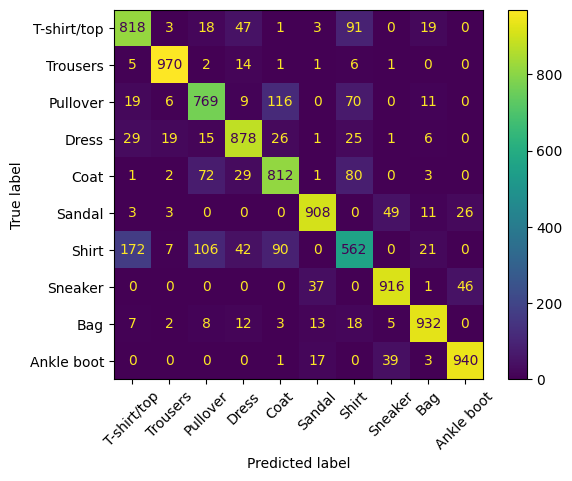

              precision    recall  f1-score   support

 T-shirt/top       0.78      0.82      0.80      1000
    Trousers       0.96      0.97      0.96      1000
    Pullover       0.78      0.77      0.77      1000
       Dress       0.85      0.88      0.86      1000
        Coat       0.77      0.81      0.79      1000
      Sandal       0.93      0.91      0.92      1000
       Shirt       0.66      0.56      0.61      1000
     Sneaker       0.91      0.92      0.91      1000
         Bag       0.93      0.93      0.93      1000
  Ankle boot       0.93      0.94      0.93      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [83]:
evaluate_classifier(y_test, predictions_svc)

As we can see, the achieved accuracy is very similar to the KNeighbors classifier, which is again quite satisfactory. The most problematic area is, again, the upper garments.

### Decision tree
The last thing that I wanted to try was the decision tree algorithm, to see if this approach would produce better results, and also since it can provide interesting visualizations by plotting the tree.

In [84]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth=16, random_state=RS)
clf.fit(X_train, y_train)
predictions_tree = clf.predict(X_test)

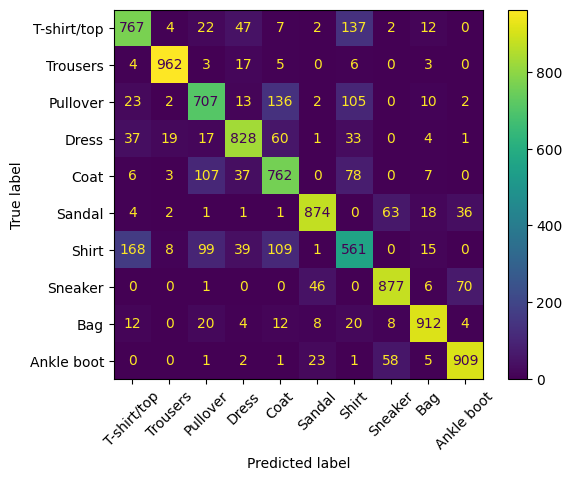

              precision    recall  f1-score   support

 T-shirt/top       0.75      0.77      0.76      1000
    Trousers       0.96      0.96      0.96      1000
    Pullover       0.72      0.71      0.71      1000
       Dress       0.84      0.83      0.83      1000
        Coat       0.70      0.76      0.73      1000
      Sandal       0.91      0.87      0.89      1000
       Shirt       0.60      0.56      0.58      1000
     Sneaker       0.87      0.88      0.87      1000
         Bag       0.92      0.91      0.92      1000
  Ankle boot       0.89      0.91      0.90      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



In [85]:
evaluate_classifier(y_test, predictions_tree)

The accuracy of 82% was the highest that I managed to achieve using this method, even when I tried increasing the tree depth. As we see, the results are slightly worse than those we got with the previous methods. The method had problems in similar areas as the previous methods - mostly within the upper garments.

The tree itself turned out to be too complex to be able to visualize in its entirety, so I decided to only display part of it by limiting the `max_depth`.

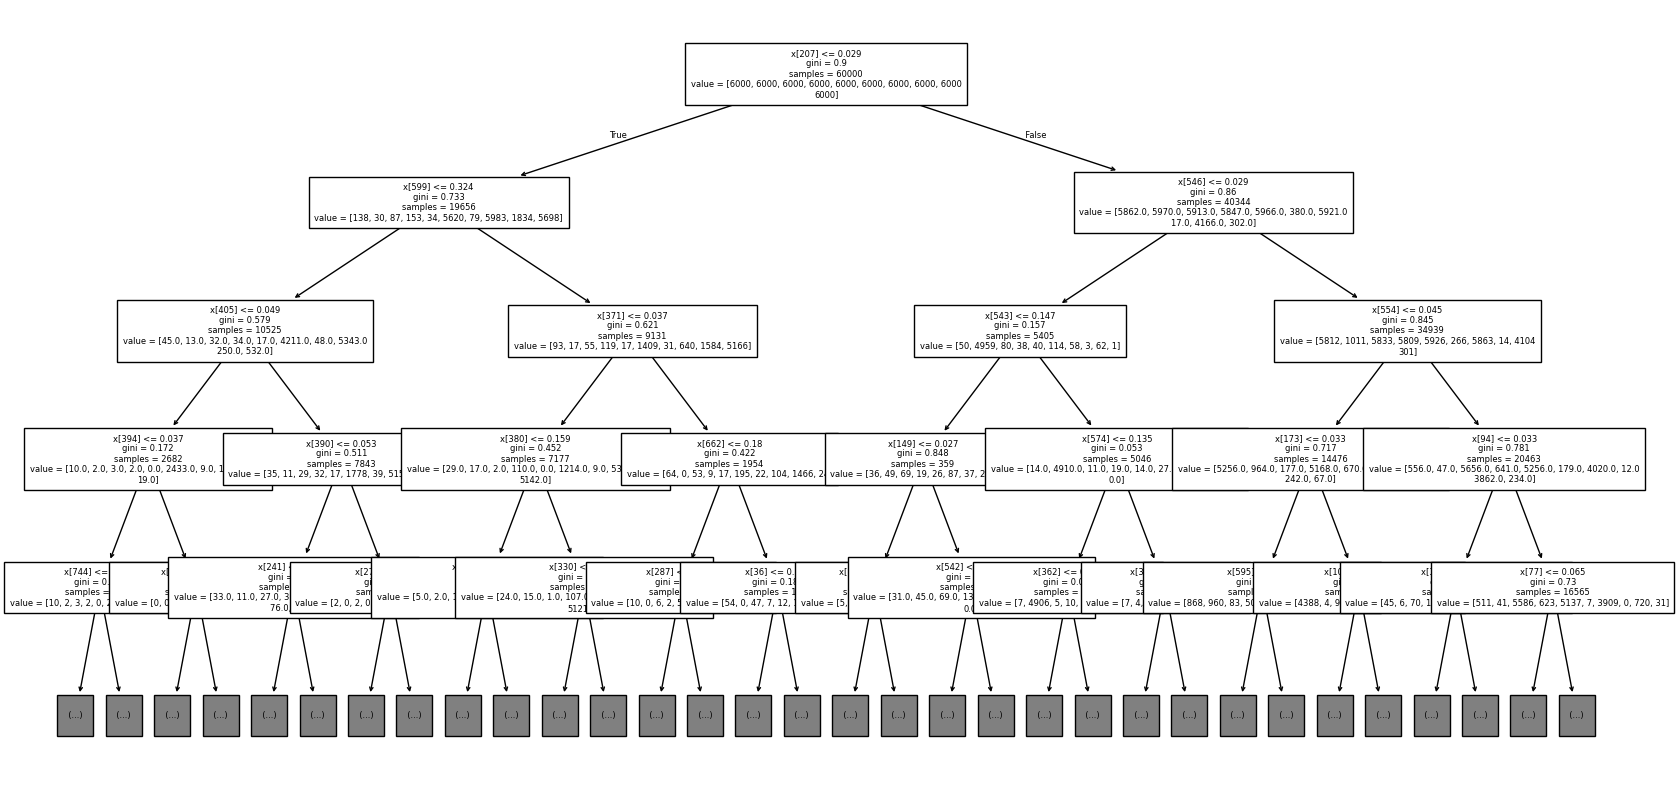

In [86]:
plt.figure(figsize=(20, 10))
tree.plot_tree(clf, label='all', max_depth=4, fontsize=6)
plt.show()

We can see that the most defining characteristics are the values of pixels:
- 207 (for 60000 images)
- 546 (for 40344 images)
- 554 (for 34939 images)
- 94  (for 20463 images)
- 599 (for 19656 images)
- 77  (for 16565 images)
- 173 (for 14476 images)
- 405 (for 10525 images)
- 371 (for 9131  images)

They are shown on the plot below (colors according to the number of images for which decision takes place, so darkest to lightest).

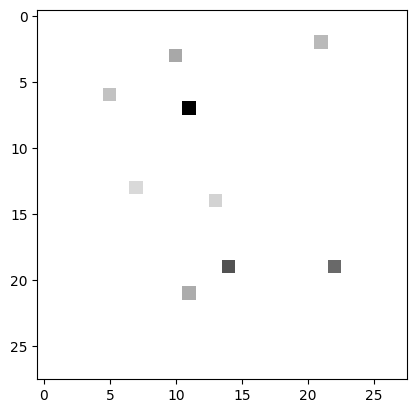

In [87]:
important_pixels = np.zeros(28*28)
important_pixels[207] = 1 * (60000 / 60000)
important_pixels[546] = 1 * (40344 / 60000)
important_pixels[554] = 1 * (34939 / 60000)
important_pixels[94]  = 1 * (20463 / 60000)
important_pixels[599] = 1 * (19656 / 60000)
important_pixels[77]  = 1 * (16565 / 60000)
important_pixels[173] = 1 * (14476 / 60000)
important_pixels[405] = 1 * (10525 / 60000)
important_pixels[371] = 1 * (9131  / 60000)
plot_image(important_pixels)

The most significant pixel makes perfect logical sense - when it's light, we are probably dealing with a shoe or a bag, and when dark, it's probably a regular clothing item. The next pixel is located somewhere inbetween the legs of trousers, and the remaining pixels are mostly on the outlines of different classes.

## ChatGPT
What follows is the approach to the problem proposed by ChatGPT model 4o, with some notes provided by me to compare its approach to mine.

### Response with summary of the approach
> Dimensionality Reduction:
> - Use PCA to reduce the dimensionality of the dataset to 50 components.
> - Apply t-SNE for further dimensionality reduction to 2D for visualization.
> Visualization:
> - Plot the 2D data from t-SNE, coloring points by their labels (classes).
> Clustering:
> - Apply k-means clustering to the PCA-reduced data.
> - Evaluate clusters using metrics like silhouette score and adjusted Rand index.
> Classification:
> - Split the data into training and test sets.
> - Train a classifier (e.g., random forest or logistic regression) on the PCA-reduced data.
> - Evaluate the model using accuracy and classification metrics like precision, recall, and F1-score.

### Code provided in the response
I had to modify the code a little bit, to make it compatible with my way of importing the data

In [88]:
# Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train = df_train_px
X_test = df_test_px

y_train = df_train['label']
y_test = df_test['label']

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

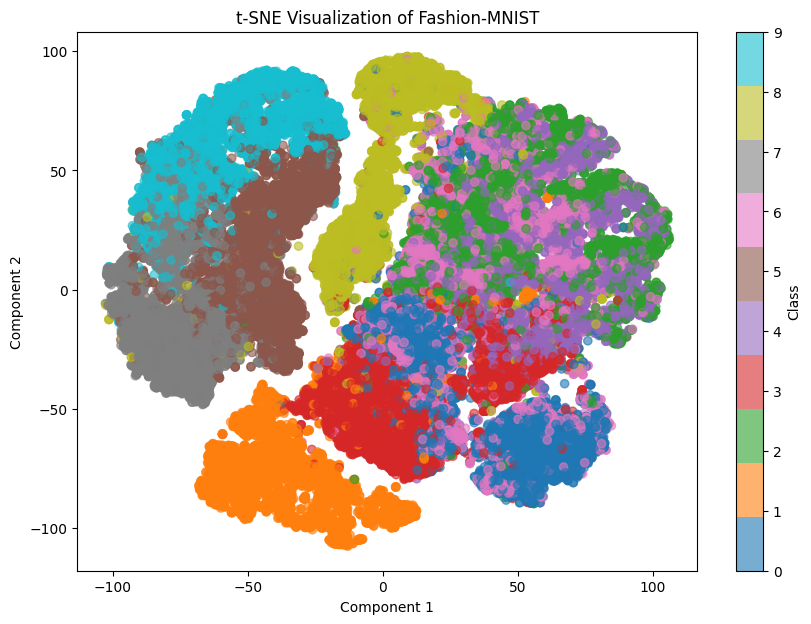

In [89]:
# Dimensionality Reduction with PCA (50 components)
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)

# Further Dimensionality Reduction with t-SNE for Visualization
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_pca)

# Visualize the 2D t-SNE data
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, ticks=range(10), label='Class')
plt.title("t-SNE Visualization of Fashion-MNIST")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

The approach to dimensionality reduction proposed by ChatGPT was quite similar to my initial attempts. It first started with PCA, which was the same thing I did. The difference was, that I calculated the desired number of components to retain 90% of the variance, and ChatGPT just picked 50.

The results achieved with the t-SNE reduction look very similar to mine.

One obvious difference in our approaches to dimensionality reduction is, of course, that ChatGPT didn't decide to try out UMAP. 

In [90]:
# Clustering with K-Means
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(X_train_pca)

# Evaluate Clustering
sil_score = silhouette_score(X_train_pca, clusters)
rand_index = adjusted_rand_score(y_train, clusters)
print(f"Silhouette Score: {sil_score:.2f}")
print(f"Adjusted Rand Index: {rand_index:.2f}")

Silhouette Score: 0.17
Adjusted Rand Index: 0.37


For clustering, ChatGPT decided to only use KMeans. The KMeans results are also similar to those that I achieved with my PCA reduced dataset. I managed to get a higher adjusted rand index by using the UMAP reduced dataset for clustering, as well as with all the other algorithms that I have tried.

In [91]:
# Classification using Random Forest
# Split data
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_pca, y_train, test_size=0.2, random_state=42)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_split, y_train_split)

# Evaluate classifier
y_pred = clf.predict(X_val_split)
report = classification_report(y_val_split, y_pred, target_names=[f"Class {i}" for i in range(10)])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.80      0.85      0.82      1232
     Class 1       0.99      0.96      0.97      1174
     Class 2       0.78      0.81      0.80      1200
     Class 3       0.85      0.90      0.88      1242
     Class 4       0.77      0.80      0.78      1185
     Class 5       0.91      0.93      0.92      1141
     Class 6       0.70      0.57      0.63      1243
     Class 7       0.92      0.91      0.92      1224
     Class 8       0.95      0.96      0.95      1149
     Class 9       0.94      0.94      0.94      1210

    accuracy                           0.86     12000
   macro avg       0.86      0.86      0.86     12000
weighted avg       0.86      0.86      0.86     12000



As for classification, ChatGPT used an algorithm I didn't consider - RandomForestClassifier. The results of using the algorithm are very similar to those that I achieved with the algoritms I have used.

### ChatGPT - Summary
The approach proposed by ChatGPT turned out to be similar too mine, and produced only slightly worse results. It managed to do so however in significantly less time than I did (a couple of seconds to generate the response, vs. around a dozen hours of experimentation).